In [1]:
# on-policy MC prediction, TD, n-step TD, TD(λ)

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gym, gym_walk, gym_aima
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P))
    while True:
        V = np.zeros(len(P))
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, iterations=100):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [9]:
def mean_return(env, pi, iterations=100):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [10]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [11]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

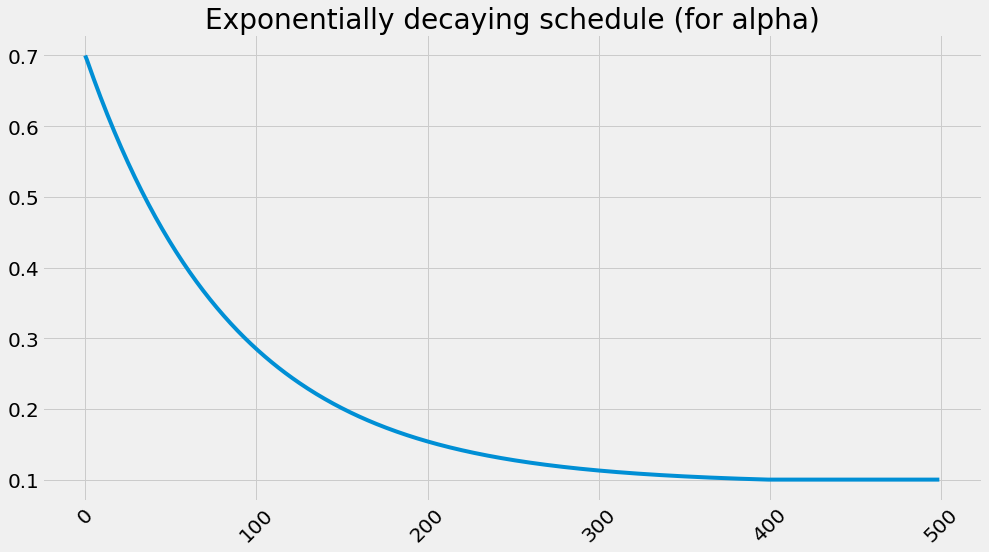

In [12]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

plt.plot([decay_schedule(0.7, 0.1, 0.8, 500, i) for i in range(500)])
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

# Random walk/Deterministic walk with uniformly random policy

In [13]:
env = gym.make('RandomWalk-v0')
P = env.env.P

LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=6)*100, 
    mean_return(env, pi)))

State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 53.00%. Obtains an average undiscounted return of 0.5300.


# Monte-Carlo prediction

In [14]:
def generate_trajectory(pi, env, max_steps=20):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [15]:
def mc_prediction(pi, 
                  env, 
                  gamma=1.0,
                  init_alpha=0.5,
                  min_alpha=0.01,
                  alpha_decay_ratio=0.3,
                  n_episodes=500, 
                  max_steps=100):
    nS = env.observation_space.n
    discounts = np.logspace(0, 
                            max_steps, 
                            num=max_steps, 
                            base=gamma, 
                            endpoint=False)
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))

    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(init_alpha, 
                               min_alpha, 
                               alpha_decay_ratio, 
                               n_episodes, 
                               e)
        trajectory = generate_trajectory(pi, 
                                         env, 
                                         max_steps)
        return_visited = np.zeros(nS, dtype=np.bool)
        for step_idx, (state, _, reward, _, _) in enumerate(trajectory):
            if return_visited[state]:
                continue
            return_visited[state] = True

            seq_len = len(trajectory[step_idx:])
            G = np.sum(discounts[:seq_len] * trajectory[step_idx:, 2])
            V[state] = V[state] + alpha * (G - V[state])
        V_track[e] = V
    return V.copy(), V_track

In [16]:
V_mcs, V_track_mcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_mc, V_track_mc = mc_prediction(pi, env)
    V_mcs.append(V_mc) ; V_track_mcs.append(V_track_mc)
V_mc, V_track_mc = np.mean(V_mcs, axis=0), np.mean(V_track_mcs, axis=0)
del V_mcs ; del V_track_mcs

In [17]:
print_state_value_function(V_mc, P, n_cols=7)
print()
print_state_value_function(V_mc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_mc, V_true))

State-value function:
|           | 01  0.172 | 02  0.339 | 03  0.509 | 04   0.67 | 05   0.82 |           |

State-value function errors:
|           | 01  0.005 | 02  0.006 | 03  0.009 | 04  0.003 | 05 -0.014 |           |
RMSE: 0.0069


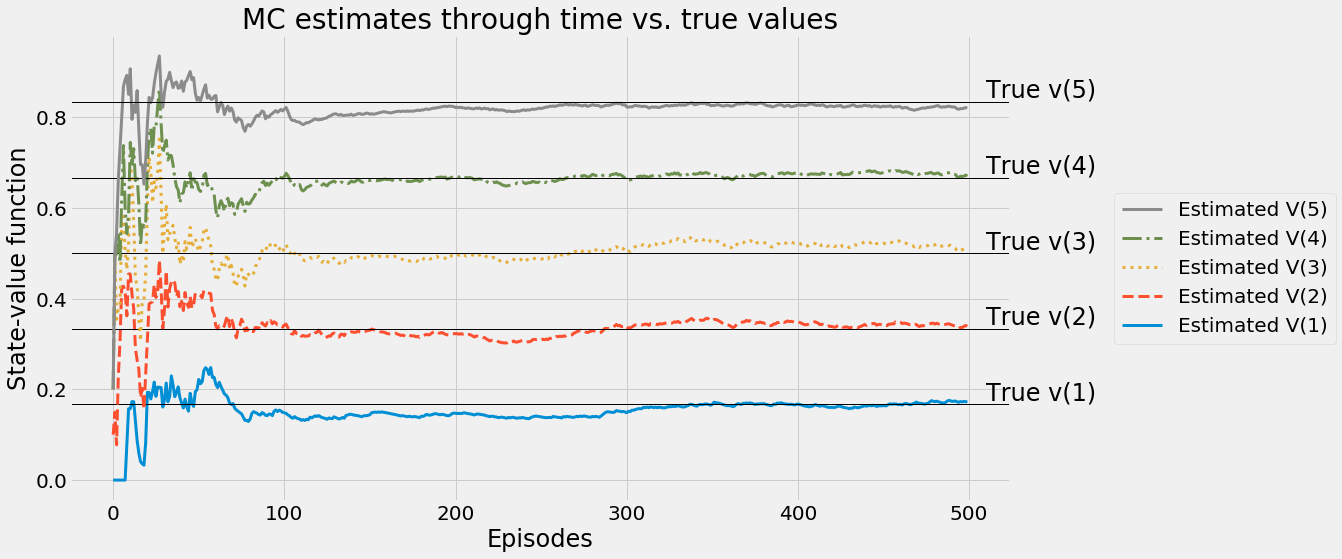

In [18]:
plot_value_function('MC estimates through time vs. true values', V_track_mc, V_true, log=False)

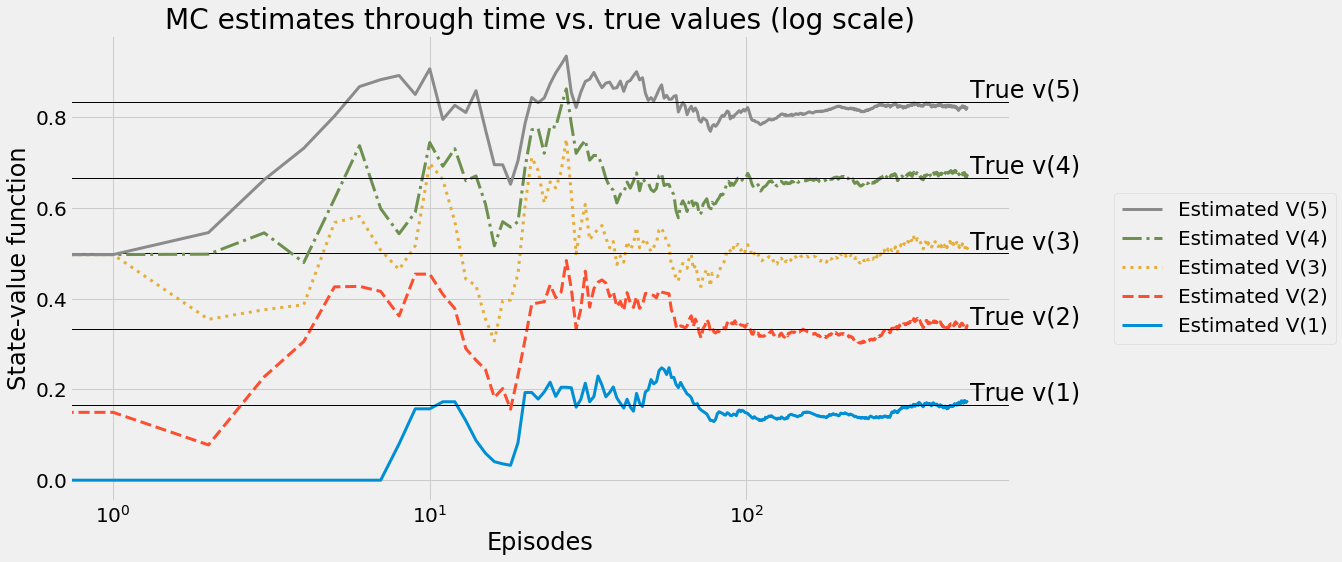

In [19]:
plot_value_function('MC estimates through time vs. true values (log scale)', V_track_mc, V_true, log=True)

# Temporal-Difference Prediction (TD)

In [20]:
def td(pi, 
       env, 
       gamma=1.0,
       init_alpha=0.5,
       min_alpha=0.01,
       alpha_decay_ratio=0.3,
       n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            V[state] = V[state] + alpha * td_error
            state = next_state
        V_track[e] = V
    return V, V_track

In [21]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td = td(pi, env)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [22]:
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
|           | 01  0.167 | 02  0.336 | 03  0.512 | 04  0.671 | 05  0.835 |           |

State-value function errors:
|           | 01    0.0 | 02  0.002 | 03  0.012 | 04  0.004 | 05  0.002 |           |
RMSE: 0.0049


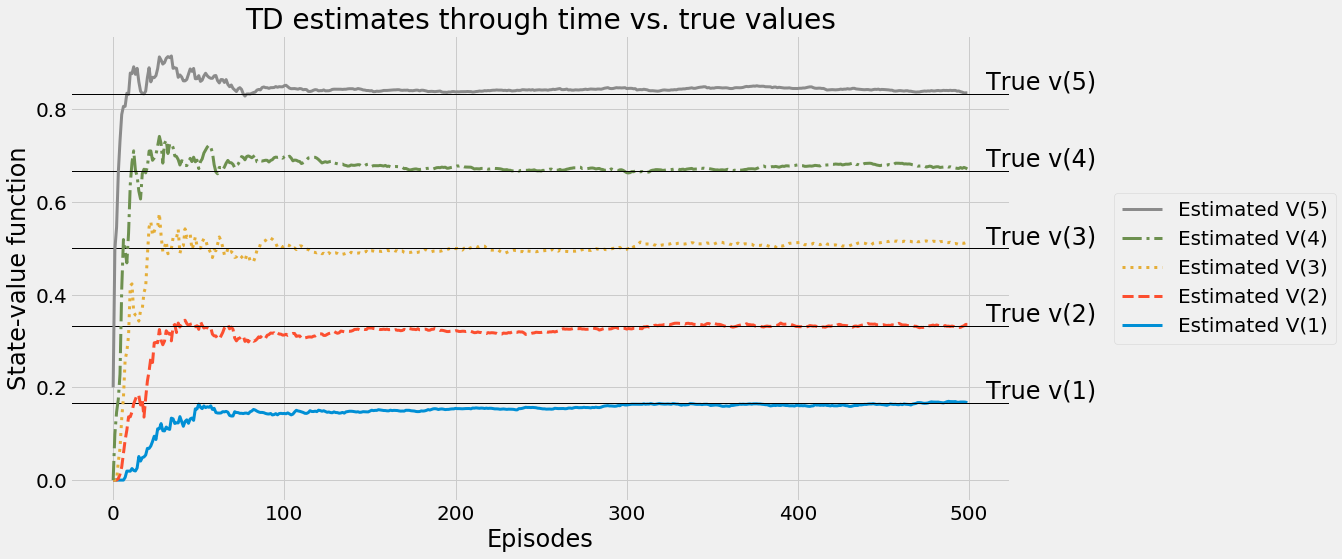

In [23]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

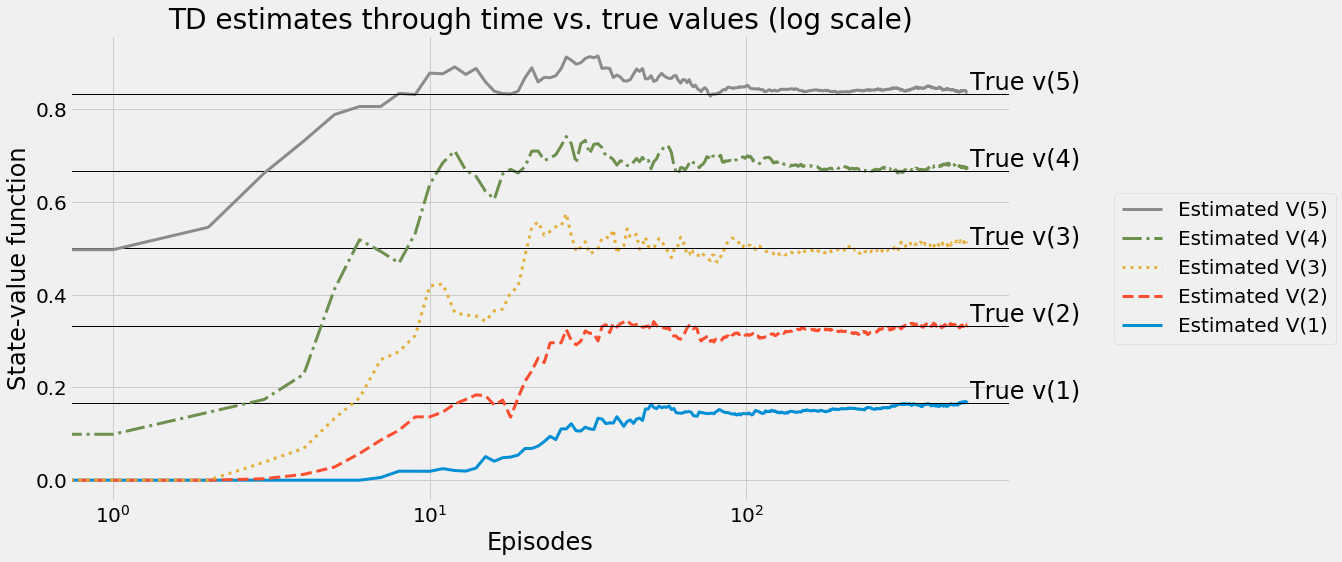

In [24]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

# Comparing MC and TD

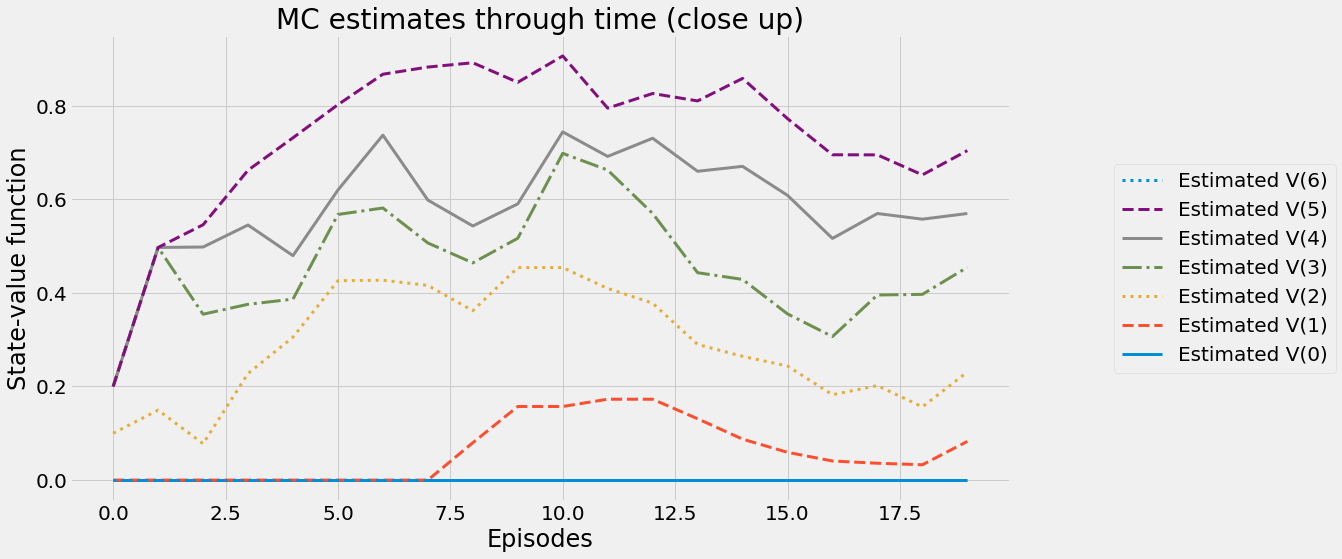

In [25]:
plot_value_function('MC estimates through time (close up)', V_track_mc[:20], None, log=False)

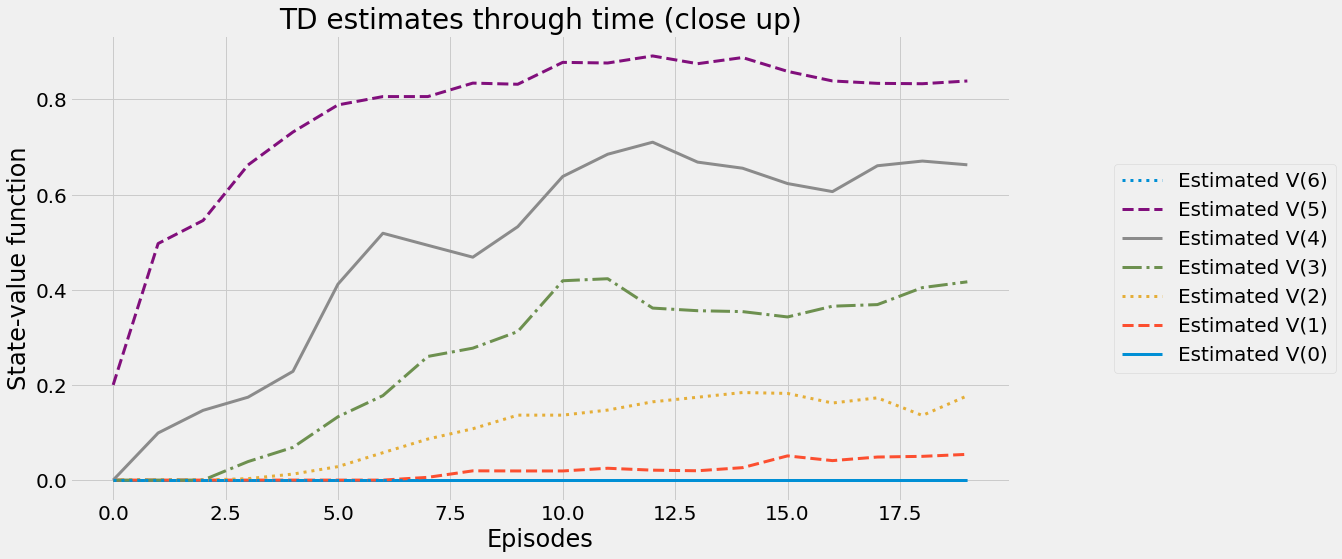

In [26]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

# n-step TD

In [27]:
def ntd(pi, 
        env, 
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.3,
        n_step=3,
        n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    gammas = np.logspace(0, n_step+1, num=n_step+1, base=gamma, endpoint=False)

    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        state, done, hist = env.reset(), False, None
        while not done or len(hist) > 0:
            if not done:
                action = pi(state)
                next_state, reward, done, _ = env.step(action)
                experience = np.array([state, reward, next_state, done], dtype=object)
                hist = experience[np.newaxis] if hist is None else np.vstack((experience, hist))[:n_step]
            if len(hist) == n_step or done:
                h = np.flip(hist, axis=0)
                ns = h[-1, 2]
                s, r, Vns, d =  h[0, 0], h[:len(h), 1], V[ns], h[-1, 3]
                G = np.sum(np.append(r * gammas[:len(h)], Vns * gammas[len(h)-1] * (not d)))
                V[s] = V[s] + alpha * (G - V[s])
                hist = hist[:-1]
            state = next_state    

        V_track[e] = V
    return V, V_track

In [28]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [29]:
print_state_value_function(V_ntd, P, n_cols=7)
print()
print_state_value_function(V_ntd - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
|           | 01  0.173 | 02  0.344 | 03  0.516 | 04  0.672 | 05  0.826 |           |

State-value function errors:
|           | 01  0.007 | 02   0.01 | 03  0.016 | 04  0.005 | 05 -0.008 |           |
RMSE: 0.0083


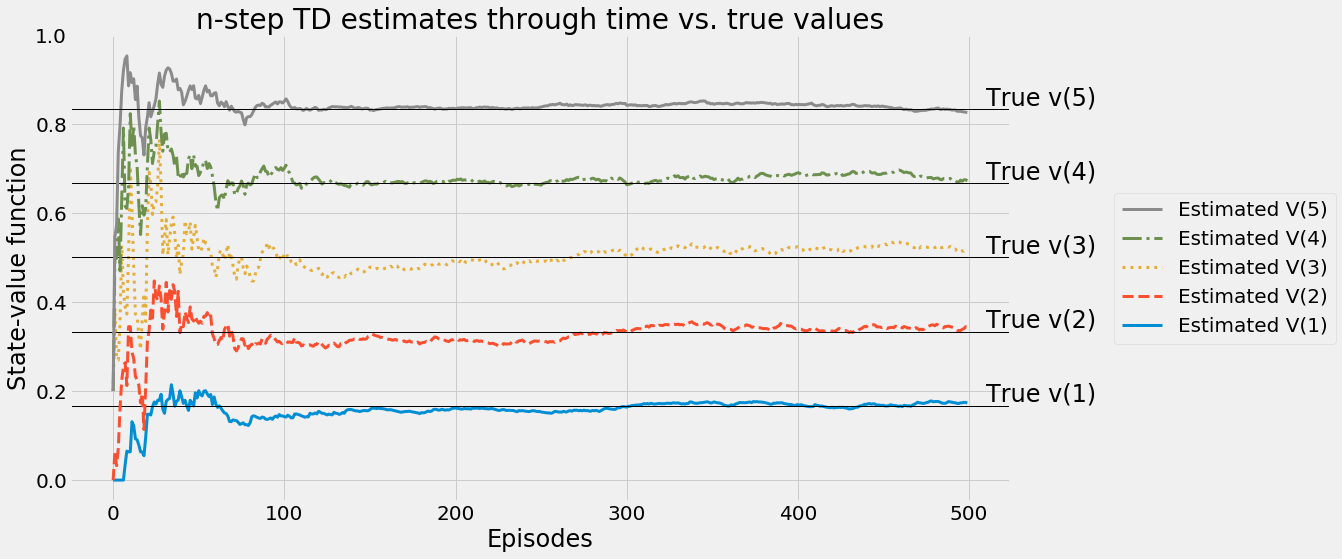

In [30]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

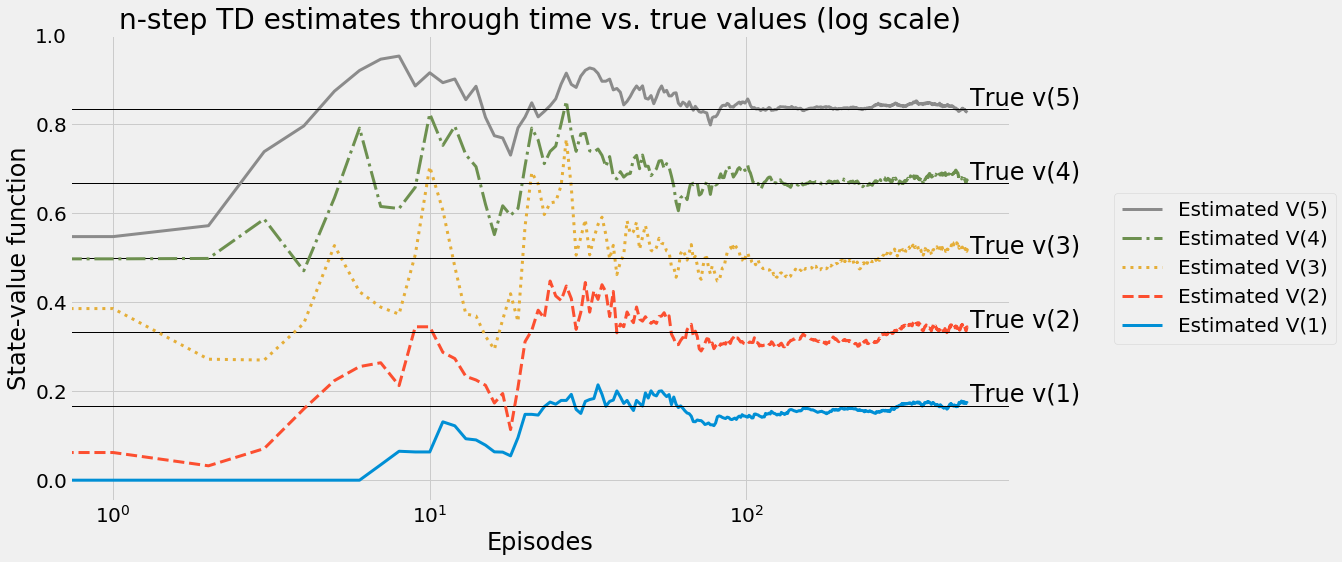

In [31]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

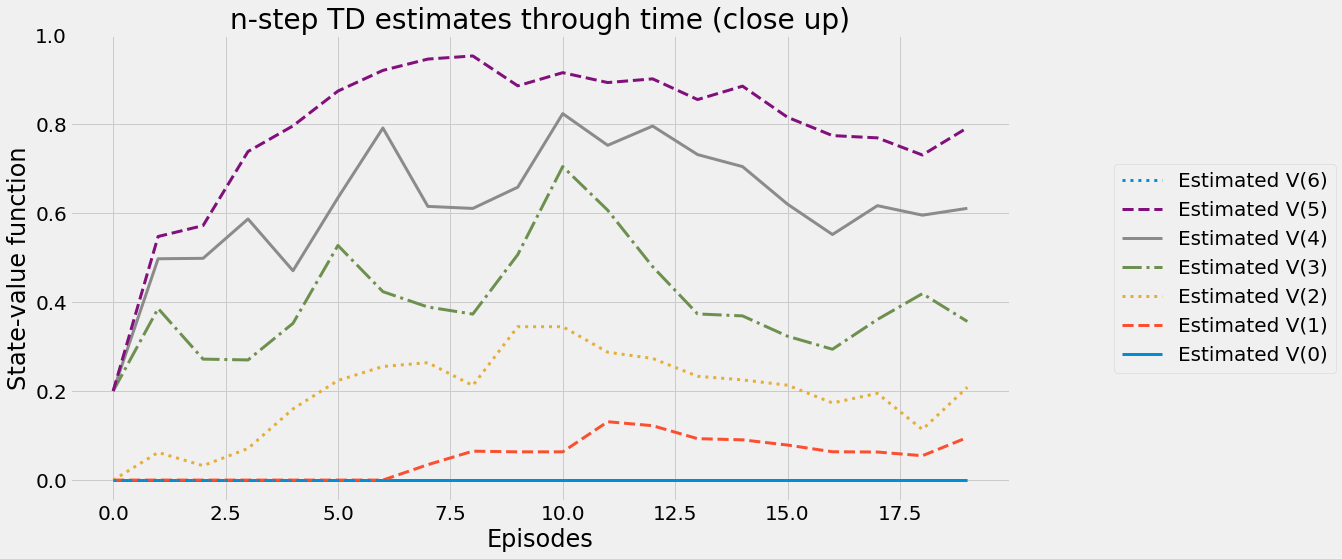

In [32]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

# TD(λ)

In [33]:
def td_lambda(pi, 
              env, 
              gamma=1.0,
              init_alpha=0.5,
              min_alpha=0.01,
              alpha_decay_ratio=0.3,
              lambda_=0.3,
              n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS)
    E = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alpha * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

In [34]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [35]:
print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
|           | 01   0.17 | 02  0.339 | 03  0.513 | 04  0.671 | 05  0.834 |           |

State-value function errors:
|           | 01  0.003 | 02  0.006 | 03  0.013 | 04  0.004 | 05    0.0 |           |
RMSE: 0.0057


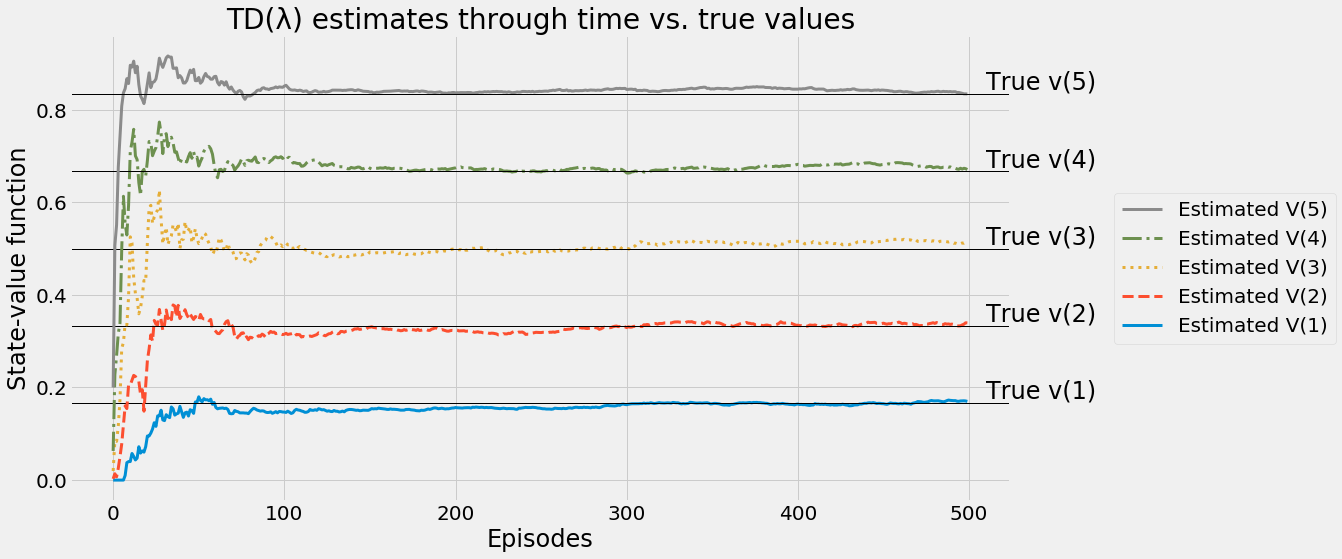

In [36]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

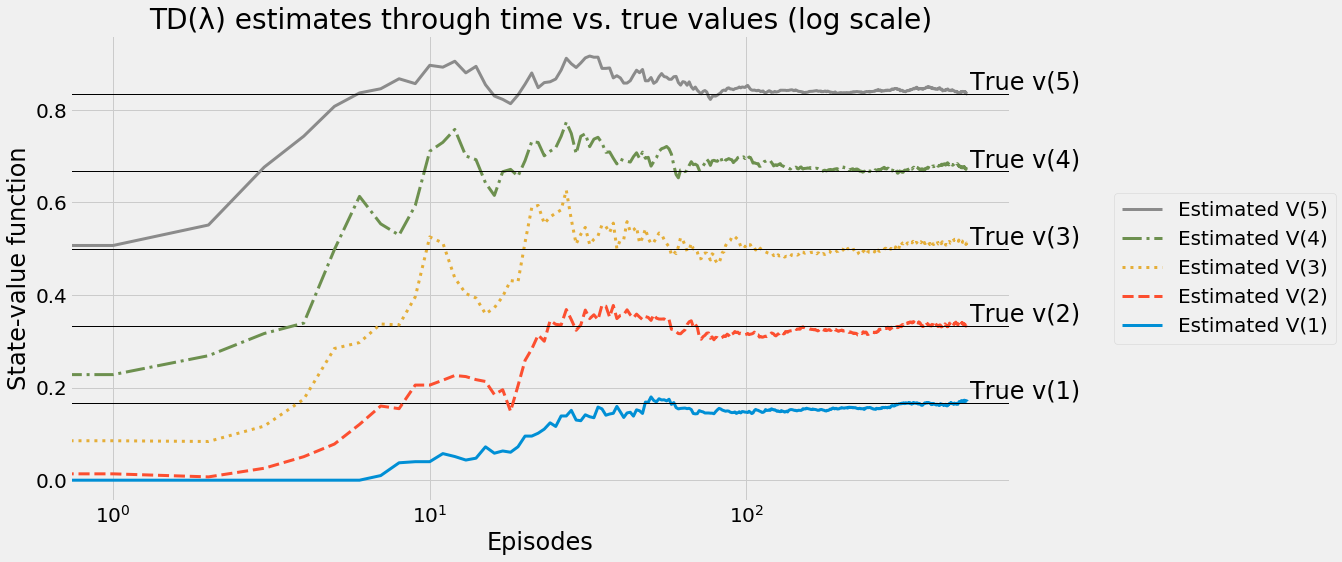

In [37]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

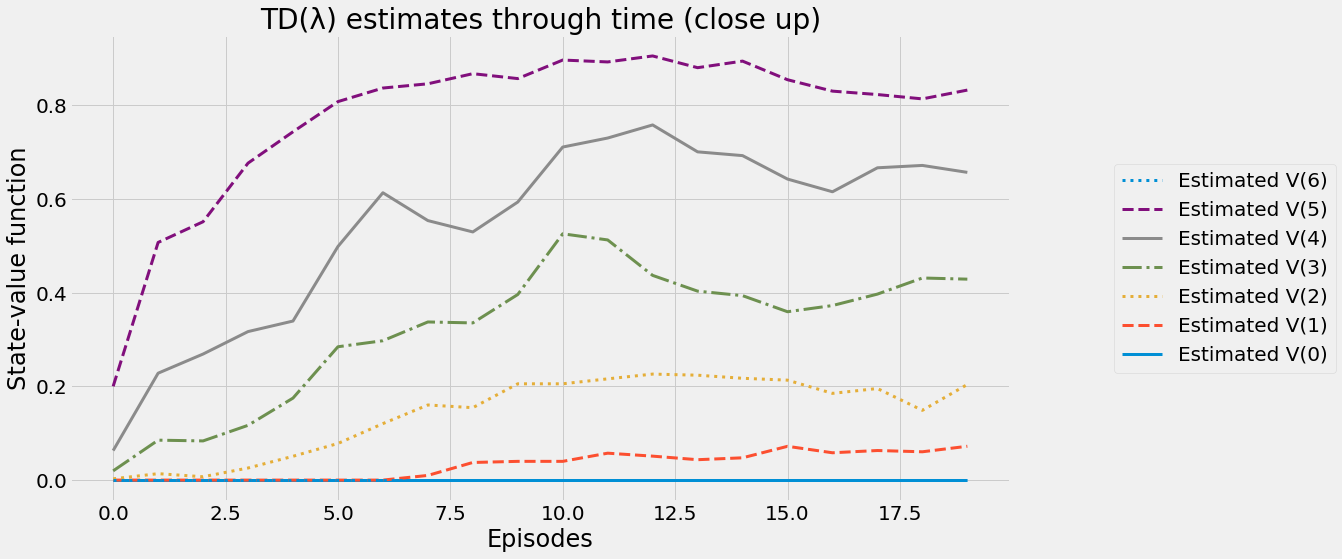

In [38]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)

# Russell & Norvig Gridworld environment and sample policy

In [39]:
env = gym.make('RussellNorvigGridworld-v0')
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:RIGHT, 5:LEFT, 6:UP, 7:LEFT,
    8:RIGHT, 9:UP, 10:UP, 11:LEFT
}[s]
print_policy(pi, P)
print('Reaches goal {:.2f}%\n'.format(probability_success(env, pi, goal_state=3)*100))

V_true = policy_evaluation(pi, P)
print_state_value_function(V_true, P)

Policy:
| 00      > | 01      > | 02      > |           |
| 04      > |           | 06      ^ |           |
| 08      > | 09      ^ | 10      ^ | 11      < |
Reaches goal 91.00%

State-value function:
| 00   0.75 | 01  0.868 | 02  0.918 |           |
| 04  0.208 |           | 06   0.66 |           |
| 08  0.065 | 09  0.097 | 10  0.529 | 11  0.315 |


# Russell & Norvig Gridworld policy estimation (policy to state-value function)

In [40]:
V_mcs, V_track_mcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_mc, V_track_mc = mc_prediction(pi, env)
    V_mcs.append(V_mc) ; V_track_mcs.append(V_track_mc)
V_mc, V_track_mc = np.mean(V_mcs, axis=0), np.mean(V_track_mcs, axis=0)
del V_mcs ; del V_track_mcs

In [41]:
print_state_value_function(V_mc, P)
print()
print_state_value_function(V_mc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_mc, V_true))

State-value function:
| 00  0.661 | 01  0.762 | 02  0.926 |           |
| 04  0.233 |           | 06  0.623 |           |
| 08  0.039 | 09  0.071 | 10  0.506 | 11  0.344 |

State-value function errors:
| 00 -0.089 | 01 -0.105 | 02  0.008 |           |
| 04  0.026 |           | 06 -0.037 |           |
| 08 -0.026 | 09 -0.027 | 10 -0.024 | 11  0.029 |
RMSE: 0.0446


In [42]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td = td(pi, env)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [43]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.525 | 01  0.799 | 02   0.92 |           |
| 04  0.064 |           | 06  0.626 |           |
| 08  0.042 | 09  0.076 | 10  0.533 | 11  0.246 |

State-value function errors:
| 00 -0.225 | 01 -0.069 | 02  0.002 |           |
| 04 -0.144 |           | 06 -0.034 |           |
| 08 -0.023 | 09 -0.021 | 10  0.004 | 11 -0.069 |
RMSE: 0.083


In [44]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [45]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00   0.69 | 01  0.815 | 02  0.924 |           |
| 04  0.226 |           | 06  0.623 |           |
| 08   0.07 | 09  0.071 | 10  0.512 | 11  0.337 |

State-value function errors:
| 00  -0.06 | 01 -0.053 | 02  0.007 |           |
| 04  0.018 |           | 06 -0.037 |           |
| 08  0.005 | 09 -0.027 | 10 -0.017 | 11  0.022 |
RMSE: 0.0284


In [46]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [47]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00  0.592 | 01  0.812 | 02  0.921 |           |
| 04  0.161 |           | 06  0.626 |           |
| 08  0.064 | 09  0.085 | 10  0.531 | 11  0.274 |

State-value function errors:
| 00 -0.158 | 01 -0.056 | 02  0.004 |           |
| 04 -0.047 |           | 06 -0.034 |           |
| 08 -0.001 | 09 -0.013 | 10  0.001 | 11 -0.041 |
RMSE: 0.0528


# FrozenLake environment and sample policy

In [48]:
env = gym.make('FrozenLake-v0')
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:RIGHT, 1:UP, 2:DOWN, 3:UP,
    4:LEFT, 5:LEFT, 6:DOWN, 7:LEFT,
    8:UP, 9:DOWN, 10:DOWN, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}[s]
print_policy(pi, P)
print('Reaches goal {:.2f}%\n'.format(probability_success(env, pi, goal_state=15)*100))

V_true = policy_evaluation(pi, P, gamma=0.99)
print_state_value_function(V_true, P)

Policy:
| 00      > | 01      ^ | 02      v | 03      ^ |
| 04      < |           | 06      v |           |
| 08      ^ | 09      v | 10      v |           |
|           | 13      > | 14      v |           |
Reaches goal 34.00%

State-value function:
| 00  0.273 | 01  0.221 | 02  0.176 | 03  0.171 |
| 04  0.333 |           | 06  0.141 |           |
| 08  0.403 | 09  0.485 | 10  0.428 |           |
|           | 13  0.639 | 14  0.812 |           |


# FrozenLake policy estimation (policy to state-value function)

In [49]:
V_mcs, V_track_mcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_mc, V_track_mc = mc_prediction(pi, env, gamma=0.99)
    V_mcs.append(V_mc) ; V_track_mcs.append(V_track_mc)
V_mc, V_track_mc = np.mean(V_mcs, axis=0), np.mean(V_track_mcs, axis=0)
del V_mcs ; del V_track_mcs

In [50]:
print_state_value_function(V_mc, P)
print()
print_state_value_function(V_mc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_mc, V_true))

State-value function:
| 00  0.292 | 01  0.233 | 02  0.179 | 03   0.17 |
| 04  0.346 |           | 06  0.149 |           |
| 08  0.417 | 09  0.494 | 10  0.432 |           |
|           | 13  0.642 | 14  0.813 |           |

State-value function errors:
| 00  0.019 | 01  0.012 | 02  0.003 | 03   -0.0 |
| 04  0.013 |           | 06  0.007 |           |
| 08  0.015 | 09  0.009 | 10  0.004 |           |
|           | 13  0.003 | 14  0.001 |           |
RMSE: 0.0082


In [51]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td = td(pi, env, gamma=0.99)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [52]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.247 | 01  0.191 | 02  0.151 | 03  0.138 |
| 04  0.308 |           | 06  0.135 |           |
| 08  0.384 | 09  0.478 | 10  0.424 |           |
|           | 13  0.623 | 14  0.805 |           |

State-value function errors:
| 00 -0.026 | 01  -0.03 | 02 -0.025 | 03 -0.033 |
| 04 -0.025 |           | 06 -0.007 |           |
| 08 -0.019 | 09 -0.007 | 10 -0.004 |           |
|           | 13 -0.016 | 14 -0.007 |           |
RMSE: 0.017


In [53]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=0.99)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [54]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00  0.312 | 01  0.243 | 02  0.193 | 03  0.189 |
| 04   0.37 |           | 06  0.157 |           |
| 08  0.446 | 09  0.518 | 10  0.445 |           |
|           | 13   0.65 | 14  0.819 |           |

State-value function errors:
| 00   0.04 | 01  0.022 | 02  0.017 | 03  0.018 |
| 04  0.037 |           | 06  0.016 |           |
| 08  0.043 | 09  0.033 | 10  0.017 |           |
|           | 13  0.011 | 14  0.007 |           |
RMSE: 0.0221


In [55]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [56]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00  0.343 | 01   0.27 | 02  0.207 | 03  0.203 |
| 04   0.41 |           | 06  0.155 |           |
| 08  0.481 | 09  0.554 | 10   0.47 |           |
|           | 13  0.693 | 14  0.845 |           |

State-value function errors:
| 00  0.071 | 01  0.049 | 02  0.032 | 03  0.033 |
| 04  0.078 |           | 06  0.014 |           |
| 08  0.078 | 09  0.069 | 10  0.042 |           |
|           | 13  0.054 | 14  0.033 |           |
RMSE: 0.0449


# FrozenLake state-value function estimation

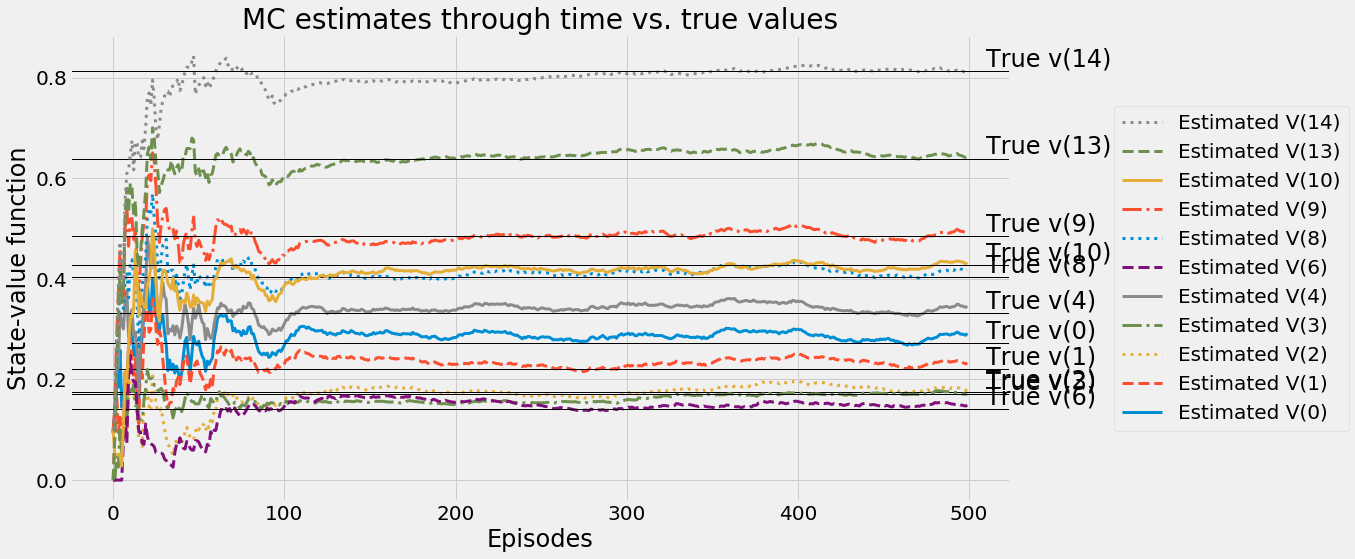

In [57]:
plot_value_function('MC estimates through time vs. true values', V_track_mc, V_true, log=False)

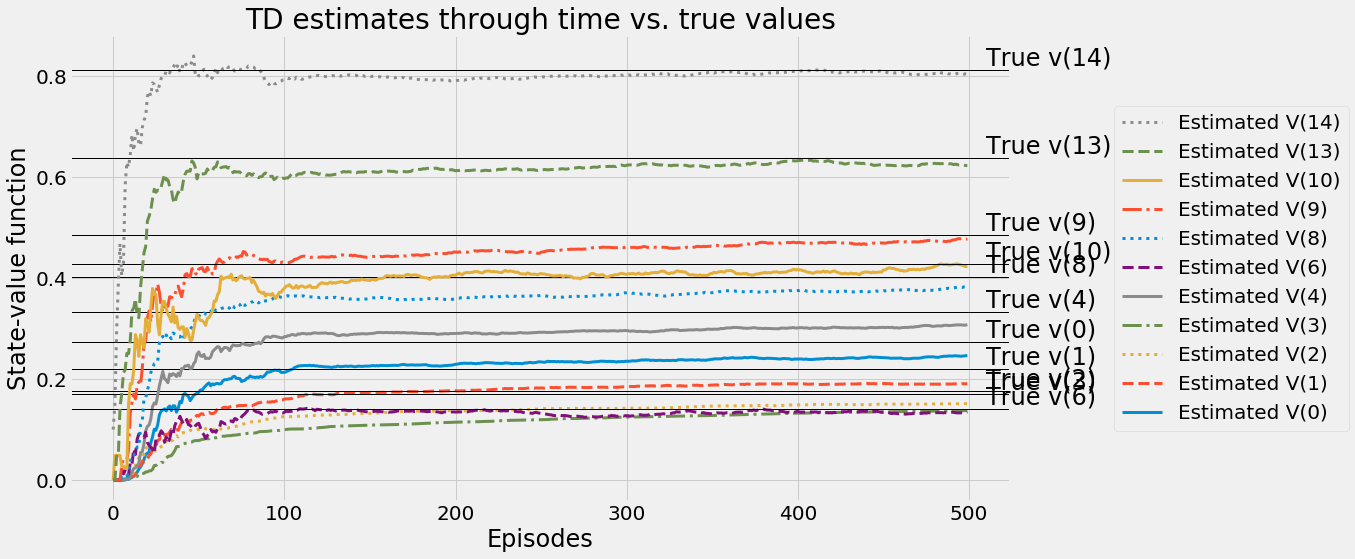

In [58]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

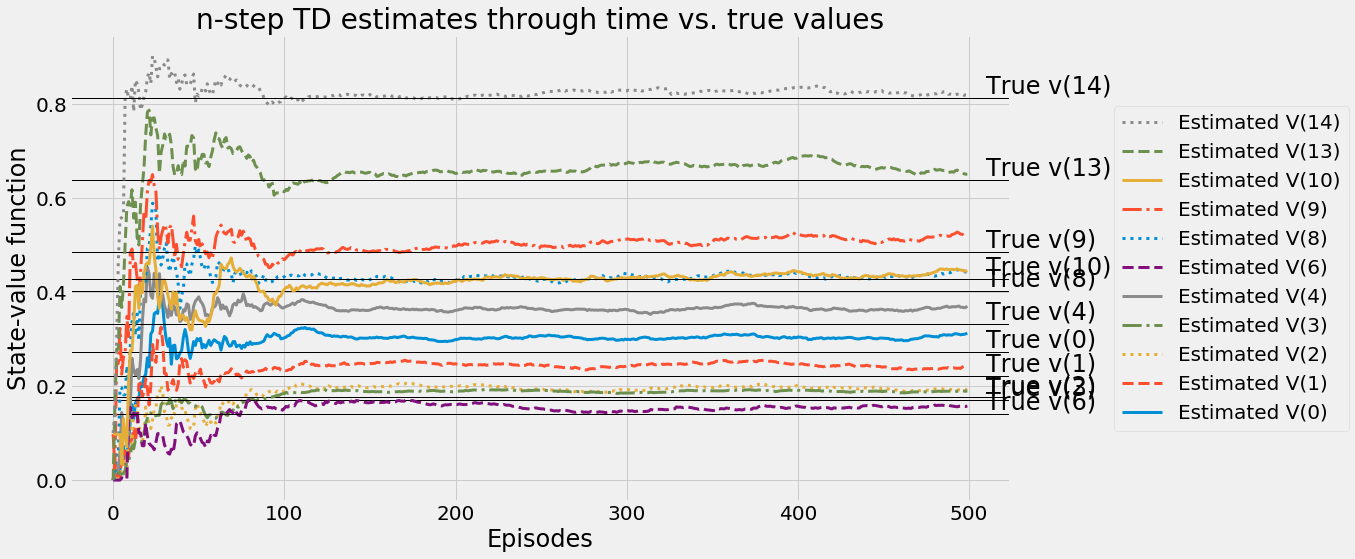

In [59]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

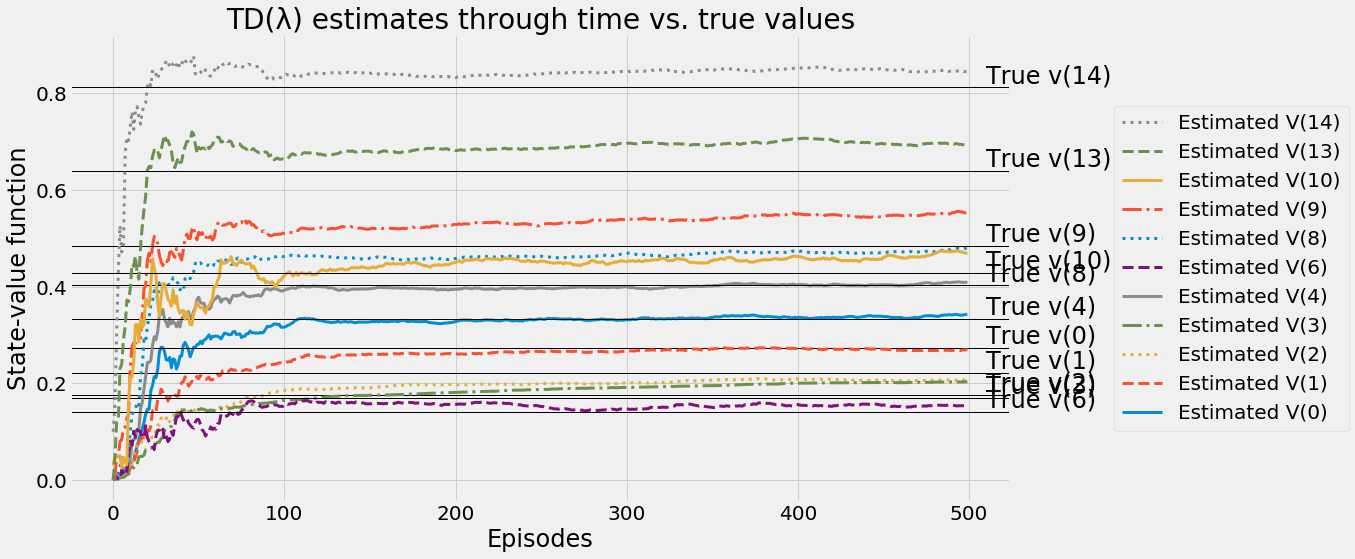

In [60]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

# FrozenLake state-value function estimation (x axis in log scale)

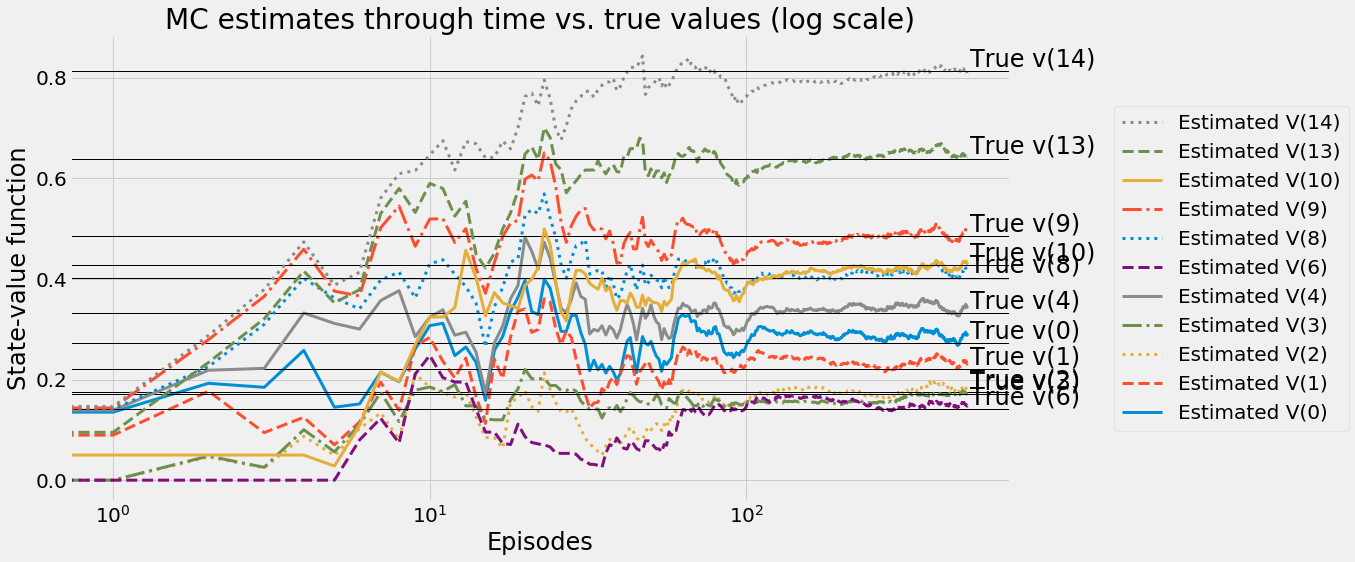

In [61]:
plot_value_function('MC estimates through time vs. true values (log scale)', V_track_mc, V_true, log=True)

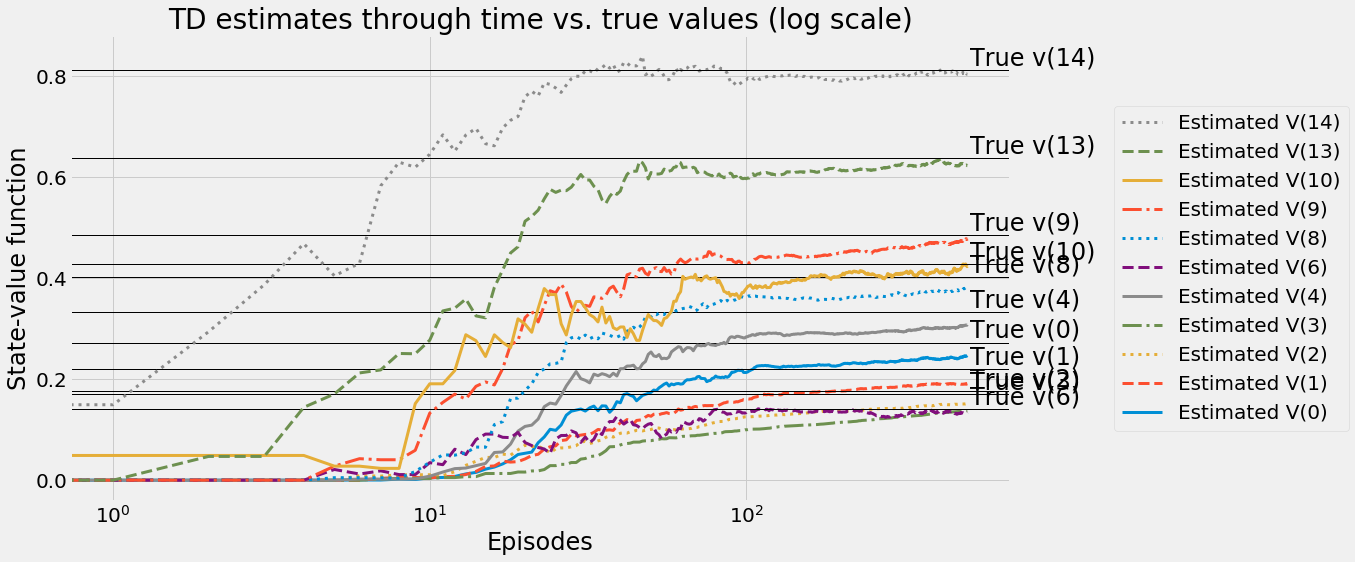

In [62]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

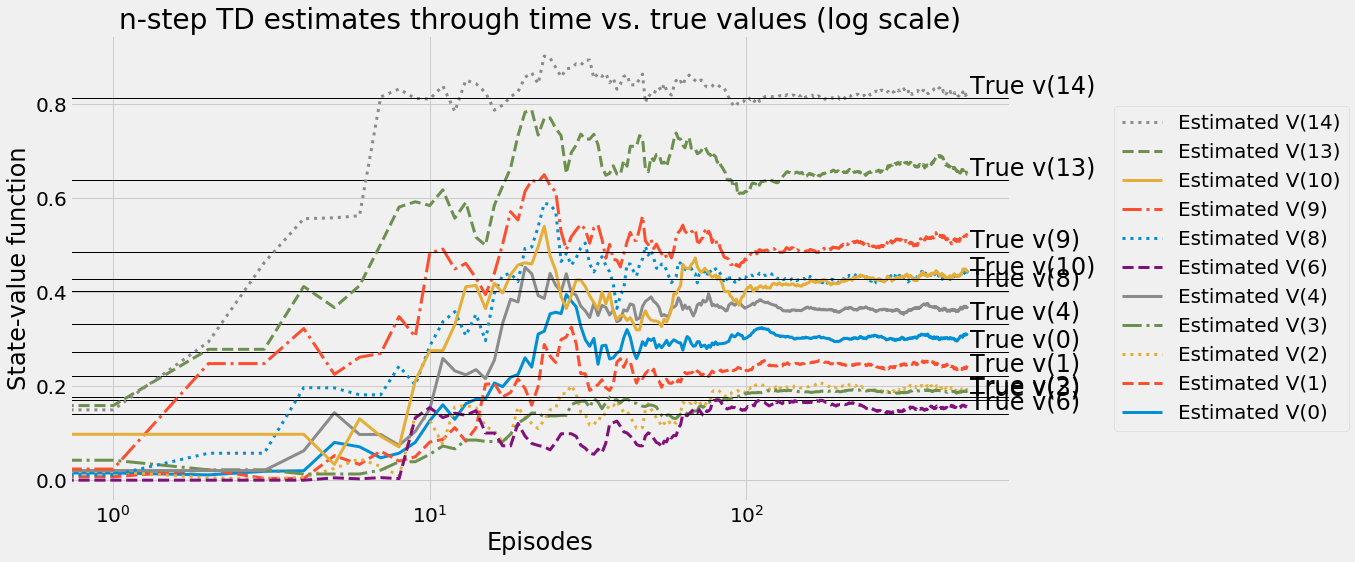

In [63]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

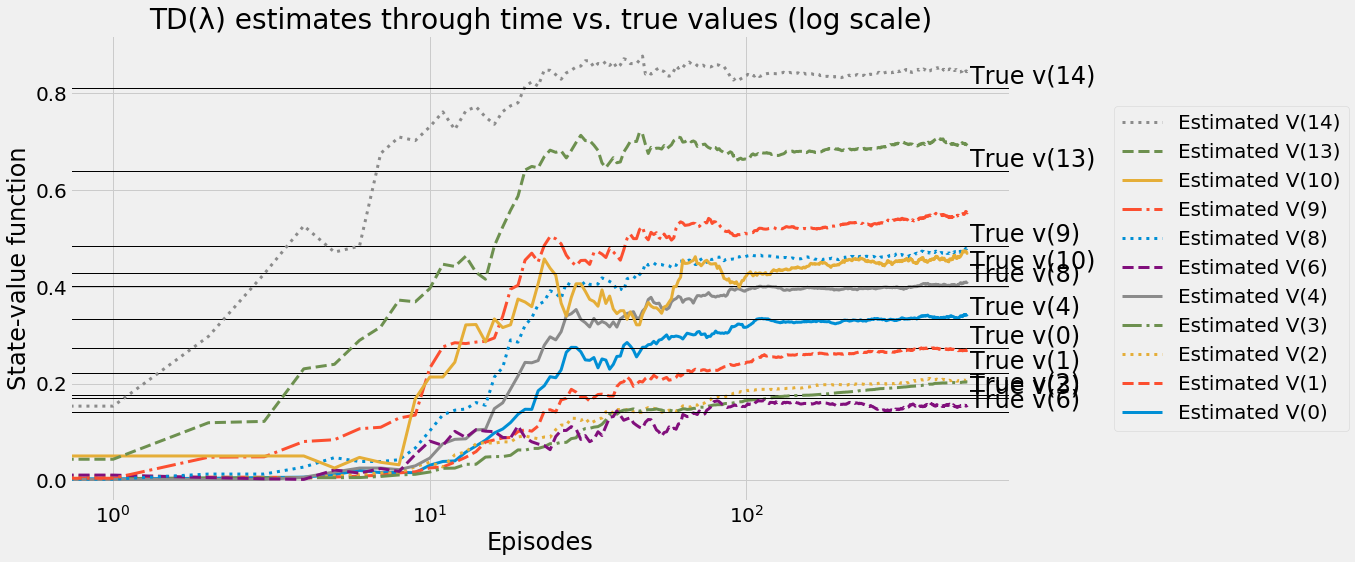

In [64]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

# Close ups

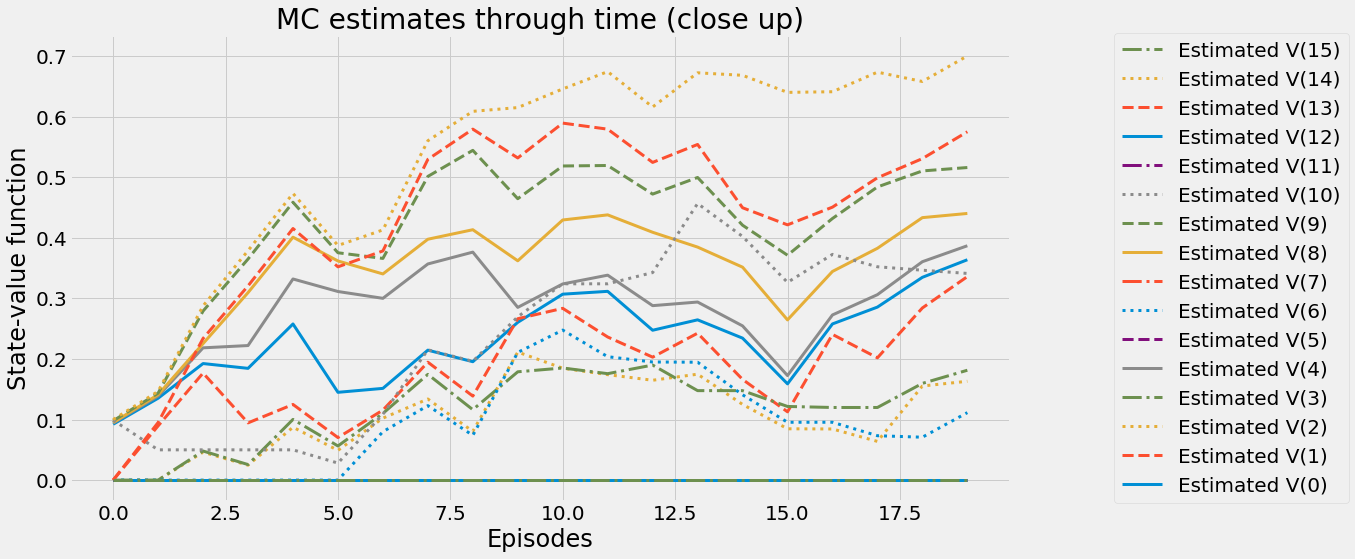

In [65]:
plot_value_function('MC estimates through time (close up)', V_track_mc[:20], None, log=False)

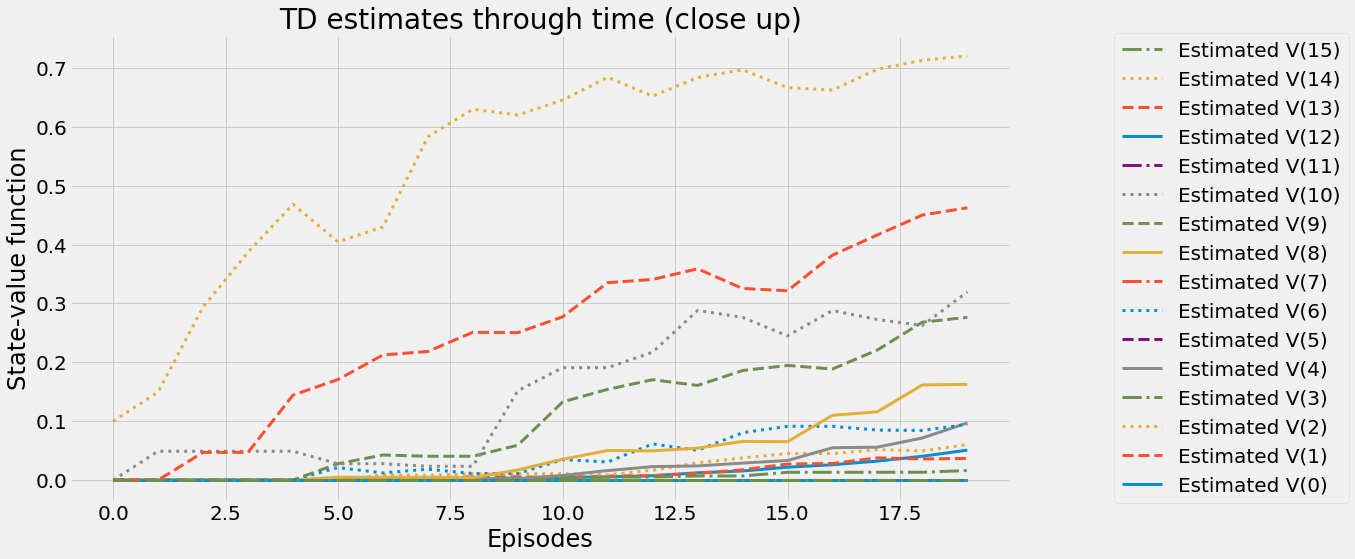

In [66]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

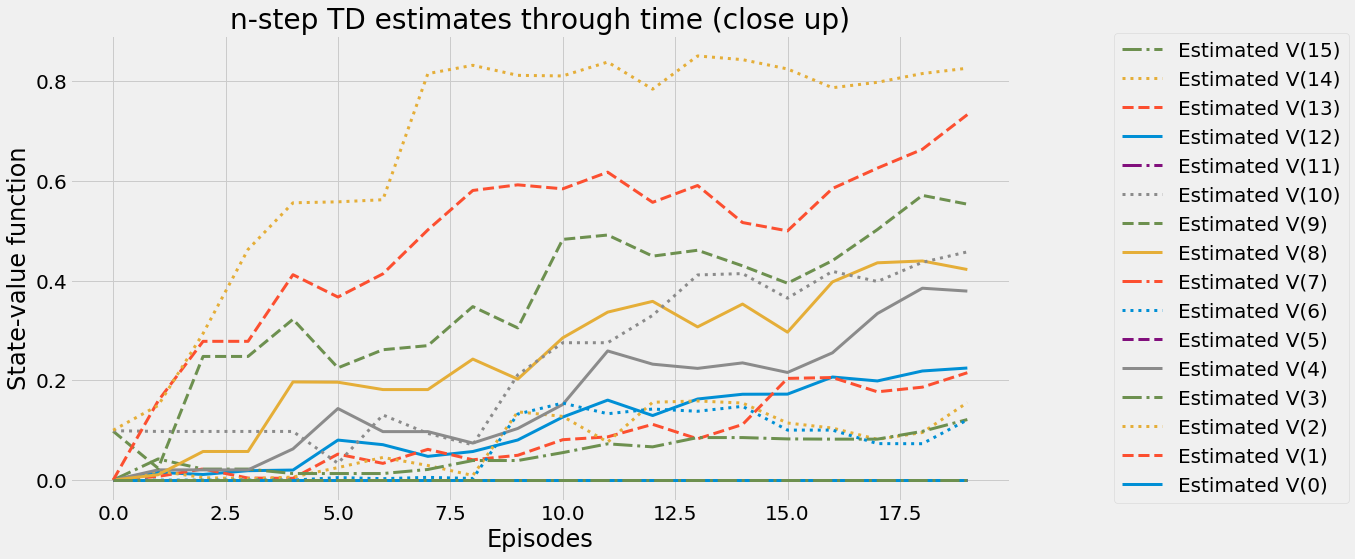

In [67]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

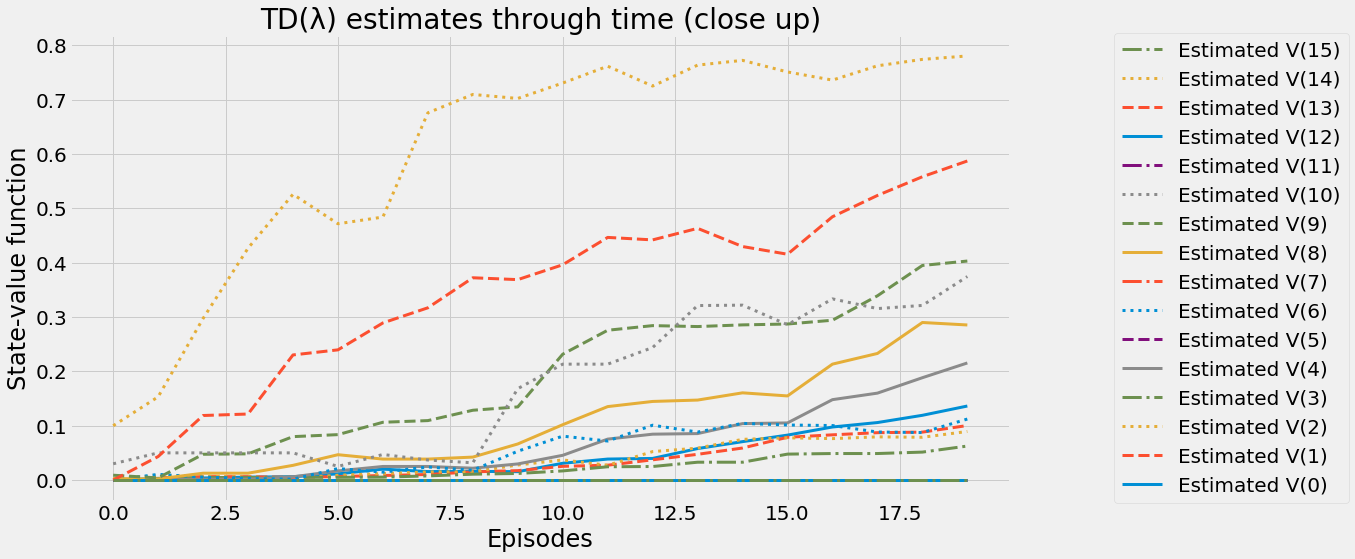

In [68]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)